<a href="https://colab.research.google.com/github/elifozkn/code/blob/master/tabtransformer_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured data learning with TabTransformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2022/01/18<br>
**Last modified:** 2022/01/18<br>
**Description:** Using contextual embeddings for structured data classification.

## Introduction

This example demonstrates how to do structured data classification using
[TabTransformer](https://arxiv.org/abs/2012.06678), a deep tabular data modeling
architecture for supervised and semi-supervised learning.
The TabTransformer is built upon self-attention based Transformers.
The Transformer layers transform the embeddings of categorical features
into robust contextual embeddings to achieve higher predictive accuracy.

This example should be run with TensorFlow 2.7 or higher,
as well as [TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Setup

In [ ]:
!pip install -U tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 25.7 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

This example uses the
[United States Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/census+income)
provided by the
[UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).
The task is binary classification
to predict whether a person is likely to be making over USD 50,000 a year.

The dataset includes 48,842 instances with 14 input features: 5 numerical features and 9 categorical features.

First, let's load the dataset from the UCI Machine Learning Repository into a Pandas
DataFrame:

In [ ]:
def data_preprocessing():
    df = df_full

    df.drop(df[['fq_frequency', 'fq_qty', 'fq_usamt','fq_quarter','Part','Cust_Country','Unnamed: 0']],
            axis=1, inplace=True)
    filter = (df.status !='')
    df = df[filter]
    # deal with categorical data
    cat_col_list = ['r_score', 'f_score', 'm_score', 'r_j_score', 'f_j_score', 'm_j_score']
   
    cat_col_list = ['cq_quarter','rfm_score', 'rfm_j_score', 'Cluster',
                    'r_score', 'f_score', 'm_score', 'r_j_score', 'f_j_score', 'm_j_score']
    for cat_col in cat_col_list:
        df[cat_col] = df[cat_col].astype(str)

    df_train, df_val = train_test_split(df, test_size=0.34, random_state=0)
    df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=0)

    train_data_file = "/content/drive/MyDrive/advantech big-data job /QoQ_retention_train_data.csv"
    val_data_file = "/content/drive/MyDrive/advantech big-data job /QoQ_retention_val_data.csv"
    test_data_file = "/content/drive/MyDrive/advantech big-data job /QoQ_retention_test_data.csv"
    full_data_file = "/content/drive/MyDrive/advantech big-data job /QoQ_retention_full_data.csv"

    df_train.to_csv(train_data_file, index=False, header=True)
    df_val.to_csv(val_data_file, index=False, header=True)
    df_test.to_csv(test_data_file, index=False, header=True)
    df.to_csv(full_data_file, index=False, header=True)

    print(df_train.shape, df_val.shape, df_test.shape)
    print(df_test.head())
    return df_train, df_val, df_test, train_data_file, val_data_file, test_data_file,full_data_file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_full = pd.read_csv("/content/drive/MyDrive/advantech big-data job /merge_base.csv")

In [ ]:
df_train, df_val, df_test, train_data_file, val_data_file, test_data_file,full_data_file = data_preprocessing()

(18109, 15) (4664, 15) (4665, 15)
       Recency  Frequency  Monetary r_score f_score m_score rfm_score  \
25962      468          1     64.89       2       4       3       243   
2388      -415          1      2.98       3       1       4       314   
26957     1389          1    260.30       4       3       2       432   
17454       78          1   2862.55       2       2       1       221   
1821       431          1      7.19       4       4       4       444   

      r_j_score f_j_score m_j_score rfm_j_score Cluster       CAI cq_quarter  \
25962         2         1         3         213       0  0.973333     202209   
2388          2         1         3         213       0  0.000000     202003   
26957         4         1         3         413       1  0.991997     202210   
17454         2         1         3         213      -1  0.979381     202110   
1821          4         1         3         413       1  0.974554     202003   

       status  
25962  retain  
2388   retain 

<Axes: xlabel='status', ylabel='count'>

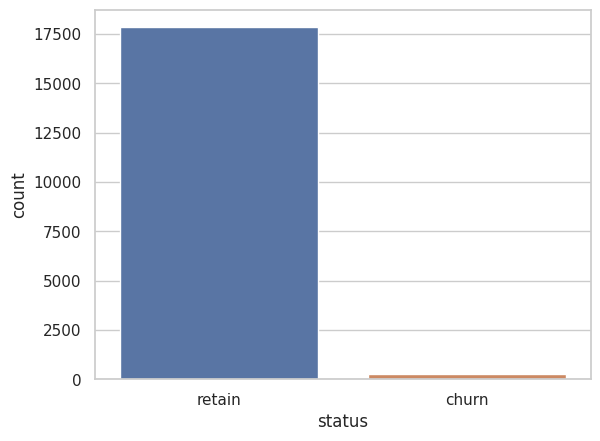

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(x=df_train["status"])

<Axes: xlabel='Cluster', ylabel='count'>

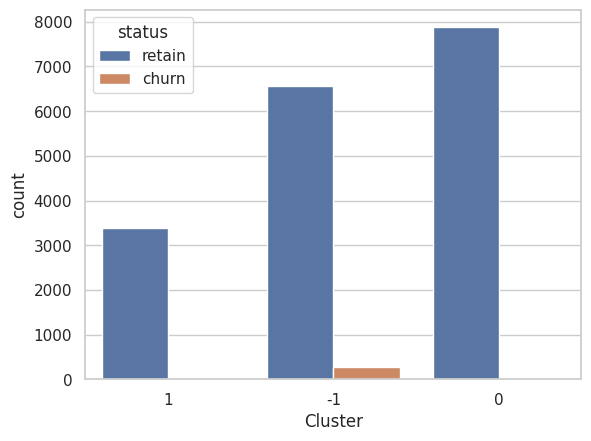

In [ ]:
sns.countplot(x=df_train["Cluster"],hue = df_train["status"])

In [ ]:
CSV_HEADER = [
        "Recency",
    "Frequency",
    "Monetary",
    "r_score",
    "f_score",
    "m_score",
    "rfm_score",
    "r_j_score",
    "f_j_score",
    "m_j_score",
    "rfm_j_score",
    "Cluster",
    "CAI",
    "cq_quarter",
    'status'
]

NUMERIC_FEATURES = [
    "Recency",

    "Monetary",
    "CAI",

]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "r_score": sorted(list(df_train["r_score"].unique())),
    "f_score": sorted(list(df_train["f_score"].unique())),
    "m_score": sorted(list(df_train["m_score"].unique())),
    "rfm_score": sorted(list(df_train["rfm_score"].unique())),
    "r_j_score": sorted(list(df_train["r_j_score"].unique())),
    "f_j_score": sorted(list(df_train["f_j_score"].unique())),
    "m_j_score": sorted(list(df_train["m_j_score"].unique())),
    "rfm_j_score": sorted(list(df_train["rfm_j_score"].unique())),
    "Cluster": sorted(list(df_train["Cluster"].unique())),
    "cq_quarter": sorted(list(df_train["cq_quarter"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "Frequency"
# A list of the categorical feature names.
CATEGORICAL_FEATURES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURES+ CATEGORICAL_FEATURES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "status"
# A list of the labels of the target features.
TARGET_LABELS = ["churn", "retain"]

In [ ]:
df_train[NUMERIC_FEATURES].describe()

,Recency,Monetary,CAI
count,18109.000000,18109.000000,18109.000000
mean,185.674250,1198.484940,0.513806
std,537.165547,5833.573091,0.480329
min,-1136.000000,-54049.170000,0.000000
25%,-232.000000,27.260000,0.000000
50%,154.000000,206.700000,0.894737
75%,530.000000,725.120100,0.975914
max,1578.000000,93312.000000,0.994396


In [ ]:
for feature in NUMERIC_FEATURES: 
  df_train[feature] = df_train[feature].astype('float64')

In [ ]:
df_test = df_test[1:]
df_train = df_train[1:]

Remove the first record (because it is not a valid data example) and a trailing 'dot' in the class labels.

Now we store the training and test data in separate CSV files.

## Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and parsing
the data into input features, and encoding the input features with respect to their types.

## Configure the hyperparameters

The hyperparameters includes model architecture and training configurations.

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

## Implement data reading pipeline

We define an input function that reads and parses the file, then converts features
and labels into a[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets)
for training or evaluation.

In [ ]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        na_value="?",
        shuffle=shuffle,
        encoding='utf-8'
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()


/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


## Implement a training and evaluation procedure

In [ ]:

def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)
    
    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history


## Create model inputs

Now, define the inputs for the models as a dictionary, where the key is the feature name,
and the value is a `keras.layers.Input` tensor with the corresponding feature shape
and data type.

In [ ]:

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


## Encode features

The `encode_inputs` method returns `encoded_categorical_feature_list` and `numerical_feature_list`.
We encode the categorical features as embeddings, using a fixed `embedding_dims` for all the features,
regardless their vocabulary sizes. This is required for the Transformer model.

In [ ]:

def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list


## Implement an MLP block

In [ ]:

def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


## Experiment 1: a baseline model

In the first experiment, we create a simple multi-layer feed-forward network.

Total model weights: 163889


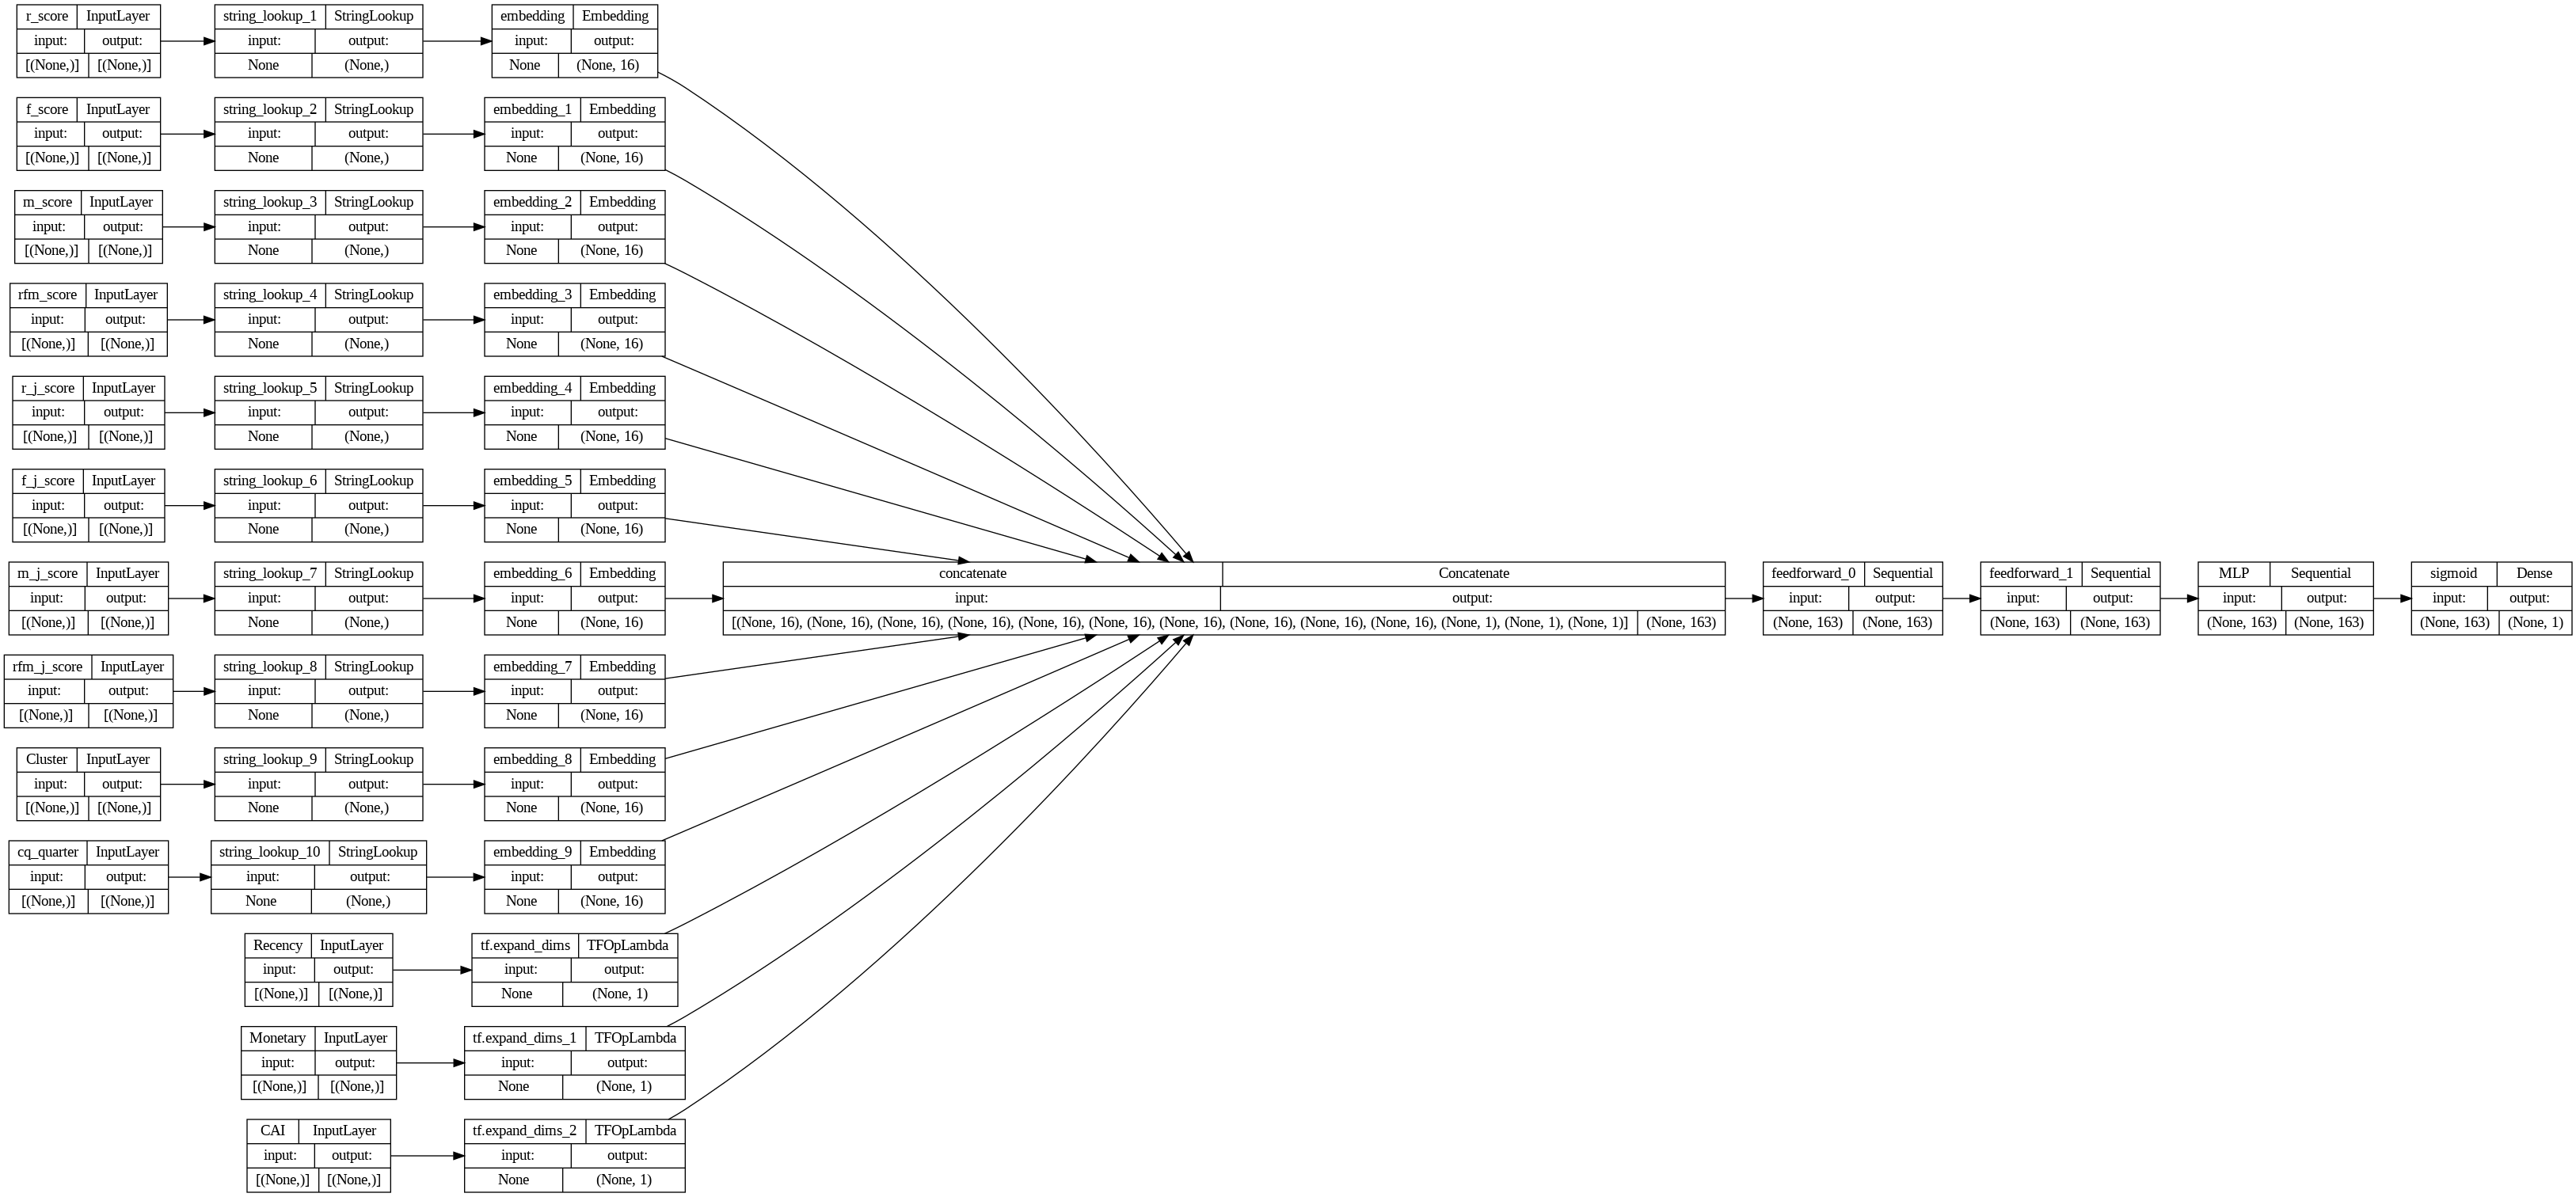

In [ ]:

def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

Let's train and evaluate the baseline model:

In [ ]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
     68/Unknown - 7s 15ms/step - loss: 0.2077 - accuracy: 0.9490

69/69 [==============================] - 9s 33ms/step - loss: 0.2070 - accuracy: 0.9493 - val_loss: 0.1091 - val_accuracy: 0.9852
Epoch 2/15
68/69 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9817

69/69 [==============================] - 1s 14ms/step - loss: 0.1229 - accuracy: 0.9818 - val_loss: 0.1146 - val_accuracy: 0.9852
Epoch 3/15
69/69 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9835

69/69 [==============================] - 2s 31ms/step - loss: 0.1183 - accuracy: 0.9835 - val_loss: 0.1243 - val_accuracy: 0.9852
Epoch 4/15
68/69 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9834

69/69 [==============================] - 3s 46ms/step - loss: 0.1169 - accuracy: 0.9835 - val_loss: 0.1071 - val_accuracy: 0.9852
Epoch 5/15
67/69 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9841

69/69 [==============================] - 2s 22ms/step - loss: 0.1122 - accuracy: 0.9841 - val_loss: 0.1119 - val_accuracy: 0.9852
Epoch 6/15
69/69 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9847

69/69 [==============================] - 1s 13ms/step - loss: 0.1093 - accuracy: 0.9847 - val_loss: 0.1124 - val_accuracy: 0.9852
Epoch 7/15
69/69 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9846

69/69 [==============================] - 1s 14ms/step - loss: 0.1085 - accuracy: 0.9846 - val_loss: 0.1135 - val_accuracy: 0.9852
Epoch 8/15
67/69 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9844

69/69 [==============================] - 1s 14ms/step - loss: 0.1103 - accuracy: 0.9844 - val_loss: 0.1097 - val_accuracy: 0.9852
Epoch 9/15
66/69 [===========================>..] - ETA: 0s - loss: 0.1069 - accuracy: 0.9846

69/69 [==============================] - 1s 15ms/step - loss: 0.1069 - accuracy: 0.9846 - val_loss: 0.1111 - val_accuracy: 0.9852
Epoch 10/15
69/69 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9846

69/69 [==============================] - 1s 13ms/step - loss: 0.1087 - accuracy: 0.9846 - val_loss: 0.1103 - val_accuracy: 0.9852
Epoch 11/15
66/69 [===========================>..] - ETA: 0s - loss: 0.1071 - accuracy: 0.9847

69/69 [==============================] - 1s 13ms/step - loss: 0.1069 - accuracy: 0.9847 - val_loss: 0.1065 - val_accuracy: 0.9852
Epoch 12/15
66/69 [===========================>..] - ETA: 0s - loss: 0.1053 - accuracy: 0.9847

69/69 [==============================] - 1s 14ms/step - loss: 0.1053 - accuracy: 0.9846 - val_loss: 0.1085 - val_accuracy: 0.9852
Epoch 13/15
67/69 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9848

69/69 [==============================] - 1s 14ms/step - loss: 0.1062 - accuracy: 0.9849 - val_loss: 0.1072 - val_accuracy: 0.9852
Epoch 14/15
67/69 [============================>.] - ETA: 0s - loss: 0.1055 - accuracy: 0.9847

69/69 [==============================] - 1s 21ms/step - loss: 0.1056 - accuracy: 0.9848 - val_loss: 0.1080 - val_accuracy: 0.9852
Epoch 15/15
66/69 [===========================>..] - ETA: 0s - loss: 0.1045 - accuracy: 0.9848

69/69 [==============================] - 1s 18ms/step - loss: 0.1043 - accuracy: 0.9848 - val_loss: 0.1060 - val_accuracy: 0.9852


Model training finished
Validation accuracy: 98.52%


The baseline linear model achieves ~81% validation accuracy.

## Experiment 2: TabTransformer

The TabTransformer architecture works as follows:

1. All the categorical features are encoded as embeddings, using the same `embedding_dims`.
This means that each value in each categorical feature will have its own embedding vector.
2. A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding.
3. The embedded categorical features are fed into a stack of Transformer blocks.
Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.
3. The outputs of the final Transformer layer, which are the *contextual embeddings* of the categorical features,
are concatenated with the input numerical features, and fed into a final MLP block.
4. A `softmax` classifer is applied at the end of the model.

The [paper](https://arxiv.org/abs/2012.06678) discusses both addition and concatenation of the column embedding in the
*Appendix: Experiment and Model Details* section.
The architecture of TabTransformer is shown below, as presented in the paper.

<img src="https://raw.githubusercontent.com/keras-team/keras-io/master/examples/structured_data/img/tabtransformer/tabtransformer.png" width="500"/>

Total model weights: 123795


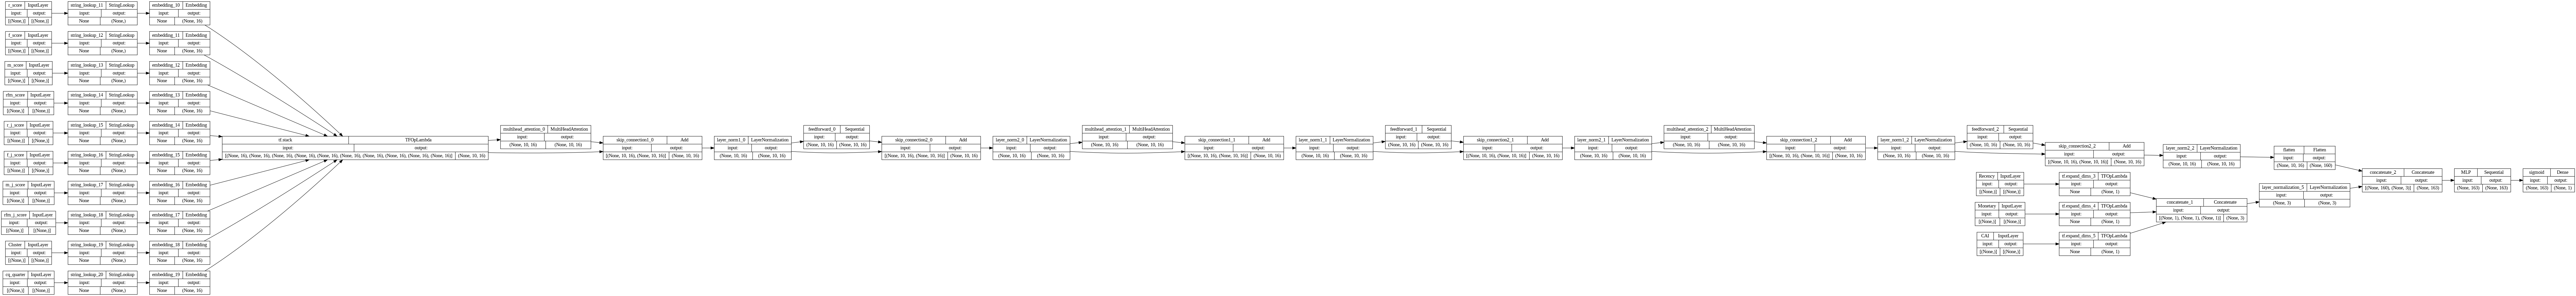

In [ ]:

def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

Let's train and evaluate the TabTransformer model:

In [ ]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
     69/Unknown - 8s 25ms/step - loss: 0.1358 - accuracy: 0.9506

69/69 [==============================] - 10s 54ms/step - loss: 0.1358 - accuracy: 0.9506 - val_loss: 0.0076 - val_accuracy: 0.9979
Epoch 2/15
67/69 [============================>.] - ETA: 0s - loss: 4.4440e-04 - accuracy: 1.0000

69/69 [==============================] - 2s 29ms/step - loss: 4.4006e-04 - accuracy: 1.0000 - val_loss: 1.6584e-04 - val_accuracy: 1.0000
Epoch 3/15
68/69 [============================>.] - ETA: 0s - loss: 3.3122e-04 - accuracy: 1.0000

69/69 [==============================] - 2s 26ms/step - loss: 3.2985e-04 - accuracy: 1.0000 - val_loss: 1.0596e-05 - val_accuracy: 1.0000
Epoch 4/15
69/69 [==============================] - ETA: 0s - loss: 1.4918e-04 - accuracy: 1.0000

69/69 [==============================] - 2s 24ms/step - loss: 1.4918e-04 - accuracy: 1.0000 - val_loss: 5.3459e-06 - val_accuracy: 1.0000
Epoch 5/15
68/69 [============================>.] - ETA: 0s - loss: 1.3315e-04 - accuracy: 1.0000

69/69 [==============================] - 2s 24ms/step - loss: 1.3298e-04 - accuracy: 1.0000 - val_loss: 3.6979e-06 - val_accuracy: 1.0000
Epoch 6/15
69/69 [==============================] - ETA: 0s - loss: 1.1382e-04 - accuracy: 1.0000

69/69 [==============================] - 2s 28ms/step - loss: 1.1382e-04 - accuracy: 1.0000 - val_loss: 2.8479e-06 - val_accuracy: 1.0000
Epoch 7/15
69/69 [==============================] - ETA: 0s - loss: 9.2388e-05 - accuracy: 1.0000

69/69 [==============================] - 3s 37ms/step - loss: 9.2388e-05 - accuracy: 1.0000 - val_loss: 2.4815e-06 - val_accuracy: 1.0000
Epoch 8/15
69/69 [==============================] - ETA: 0s - loss: 6.5124e-05 - accuracy: 1.0000

69/69 [==============================] - 2s 27ms/step - loss: 6.5124e-05 - accuracy: 1.0000 - val_loss: 2.2934e-06 - val_accuracy: 1.0000
Epoch 9/15
67/69 [============================>.] - ETA: 0s - loss: 5.5378e-05 - accuracy: 1.0000

69/69 [==============================] - 2s 23ms/step - loss: 5.5296e-05 - accuracy: 1.0000 - val_loss: 2.0048e-06 - val_accuracy: 1.0000
Epoch 10/15
68/69 [============================>.] - ETA: 0s - loss: 5.3278e-05 - accuracy: 1.0000

69/69 [==============================] - 2s 23ms/step - loss: 5.3161e-05 - accuracy: 1.0000 - val_loss: 1.5932e-06 - val_accuracy: 1.0000
Epoch 11/15
69/69 [==============================] - ETA: 0s - loss: 4.1007e-05 - accuracy: 1.0000

69/69 [==============================] - 2s 23ms/step - loss: 4.1007e-05 - accuracy: 1.0000 - val_loss: 1.7536e-06 - val_accuracy: 1.0000
Epoch 12/15
68/69 [============================>.] - ETA: 0s - loss: 4.1045e-05 - accuracy: 1.0000

69/69 [==============================] - 2s 26ms/step - loss: 4.1014e-05 - accuracy: 1.0000 - val_loss: 1.5672e-06 - val_accuracy: 1.0000
Epoch 13/15
69/69 [==============================] - ETA: 0s - loss: 6.5190e-05 - accuracy: 1.0000

69/69 [==============================] - 2s 35ms/step - loss: 6.5190e-05 - accuracy: 1.0000 - val_loss: 3.2513e-06 - val_accuracy: 1.0000
Epoch 14/15
68/69 [============================>.] - ETA: 0s - loss: 3.1380e-05 - accuracy: 1.0000

69/69 [==============================] - 2s 30ms/step - loss: 3.2412e-05 - accuracy: 1.0000 - val_loss: 1.5087e-06 - val_accuracy: 1.0000
Epoch 15/15
69/69 [==============================] - ETA: 0s - loss: 2.9695e-05 - accuracy: 1.0000

69/69 [==============================] - 2s 27ms/step - loss: 2.9695e-05 - accuracy: 1.0000 - val_loss: 1.4101e-06 - val_accuracy: 1.0000


Model training finished
Validation accuracy: 100.0%


In [ ]:
import numpy as np
import pandas as pd

import datetime as dt

import warnings
from datetime import date
import math
## Importing the main library used to connect to Denodo via ODBC (libpq)
import psycopg2 as dbdriver
#pip install psycopg2-binary


## Importing the gethostname function from socket to
## put the hostname in the useragent variable
from socket import gethostname

warnings.filterwarnings("ignore")
# global variable for pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

#This setting allow see all columns
pd.options.display.max_columns = None


In [ ]:
from sklearn.metrics import roc_curve,auc,precision_score,f1_score,recall_score
from numpy import argmax
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import backend as K

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

215/215 [==============================] - 3s 9ms/step


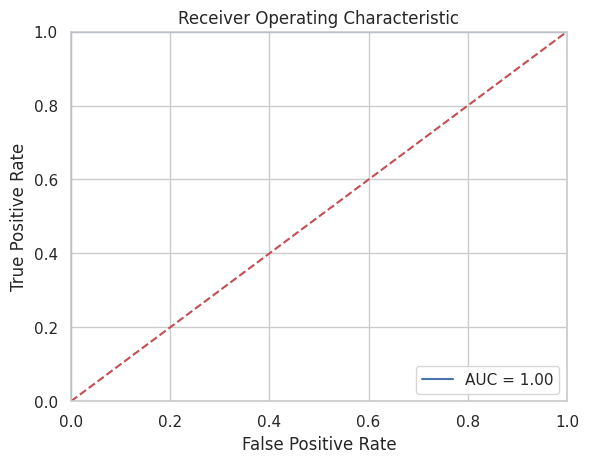

Best probability threshold:  0.9999336
Predictions probability: 0.9999998807907104, Predictions: retain, Actual: retain
Predictions probability: 0.9999998807907104, Predictions: retain, Actual: retain
Predictions probability: 0.9999998807907104, Predictions: retain, Actual: retain
Predictions probability: 0.9999995231628418, Predictions: retain, Actual: retain
Predictions probability: 0.9999995231628418, Predictions: retain, Actual: retain
Predictions probability: 0.9999997615814209, Predictions: retain, Actual: retain
Predictions probability: 1.0, Predictions: retain, Actual: retain
Predictions probability: 0.9999969005584717, Predictions: retain, Actual: retain
Predictions probability: 0.9999973773956299, Predictions: retain, Actual: retain
Predictions probability: 0.9999909400939941, Predictions: retain, Actual: retain
Predictions probability: 1.0, Predictions: retain, Actual: retain
Predictions probability: 0.9999972581863403, Predictions: retain, Actual: retain
Predictions probabi

In [ ]:
def Find_Optimal_Cutoff(target, predicted):

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(target, predicted)
    # get the best threshold
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    J = tpr - fpr
    ix = argmax(J)
    best_thresh = thresholds[ix]
    return best_thresh


def compute_predictions(model, data_file_path):
    dataset_df = pd.read_csv(data_file_path)
    dataset_df["y_actual"] = dataset_df['status'].map(lambda x: 1 if x == 'retain' else 0)

    dataset_tf = get_dataset_from_csv(data_file_path)
    y_pred_proba_nd = model.predict(dataset_tf)
    dataset_df["y_pred_probaility"] = pd.DataFrame(y_pred_proba_nd)

    # find the best threshold
    best_threshold = Find_Optimal_Cutoff(dataset_df["y_actual"], dataset_df["y_pred_probaility"])
    print("Best probability threshold: ", best_threshold)

    # convert probability to class label based on threshold
    dataset_df["y_pred_classes"] = dataset_df["y_pred_probaility"].map(lambda x: "retain" if x > best_threshold else "churn")

    # y_pred_classes = np.where(y_pred_probaility > threshold, 'retain', 'churn')

    for idx in range(len(dataset_df[:30])):
        print(
            f"Predictions probability: {dataset_df['y_pred_probaility'][idx]}, "
            f"Predictions: {dataset_df['y_pred_classes'][idx]}, "
            f"Actual: {dataset_df[TARGET_FEATURE_NAME][idx]}"
        )
    dataset_df.to_csv("/content/drive/MyDrive/advantech big-data job /output.csv")
    return best_threshold


# predict with y label
optimal_threshold = compute_predictions(tabtransformer_model, full_data_file)

def compute_predictions_with_out_y(model, data_file_path):
    dataset_df = pd.read_csv(data_file_path)

    dataset_tf = get_dataset_from_csv(data_file_path)
    y_pred_proba_nd = model.predict(dataset_tf)
    print(y_pred_proba_nd )
    dataset_df["y_pred_probaility"] = pd.DataFrame(y_pred_proba_nd)

    # convert probability to class label based on threshold
    dataset_df["y_pred_classes"] = dataset_df["y_pred_probaility"].map(
        lambda x: "retain" if x > optimal_threshold else "churn")


    # y_pred_classes = np.where(y_pred_probaility > threshold, 'retain', 'churn')

    for idx in range(len(dataset_df[:30])):
        print(
            f"Predictions probability: {dataset_df['y_pred_probaility'][idx]}, "
            f"Predictions: {dataset_df['y_pred_classes'][idx]}, "
            f"Actual: {dataset_df[TARGET_FEATURE_NAME][idx]}"
        )
    dataset_df.drop(dataset_df[['part']],
            axis=1, inplace=True)
    dataset_df.to_csv("/content/drive/MyDrive/advantech big-data job /output.csv")

# predict without y label